In [96]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [97]:
from sklearn.model_selection import train_test_split
import pandas as pd
import sklearn
import xgboost
import shap

In [98]:
dataset = pd.read_csv('/content/drive/MyDrive/big_5/df_texts_ocean.csv')
features = pd.read_csv('/content/drive/MyDrive/big_5/big_5_features.csv')

In [99]:
dataset.head(2)

,user_id,post_text,Экстраверсия,Доброжелательность,Сознательность,Нейротизм,Открытость опыту,Экстраверсия_3,Доброжелательность_3,Сознательность_3,Нейротизм_3,Открытость опыту_3,Экстраверсия_5,Доброжелательность_5,Сознательность_5,Нейротизм_5,Открытость опыту_5,post_text_preprocessed
0,133,Открытое образование - Главная страница,4.88,4.11,4.67,1.13,4.9,2,2,2,0,2,4,3,4,0,4,открытое образование PUNK главная страница
1,133,Первый день форума «Бережливое управление 2.0»,4.88,4.11,4.67,1.13,4.9,2,2,2,0,2,4,3,4,0,4,первый день форума PUNK бережливое управление ...


In [100]:
features.head(2)

,adjs,advs,punkts,prons_1,prons_2,prons_3,nums,urls,conjunct,discourse,...,tense_past,tense_pres,mood_indc,mood_impr,aspect_perf,aspect_impf,emoji,hashtags,length,max_depth
0,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,2
1,2,0,3,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,6,3


In [101]:
def get_train_test(dataset, features, PREDICT_COLUMN):
  df = features.copy()

  df[PREDICT_COLUMN] = dataset[PREDICT_COLUMN]
  df['stratify'] = dataset[f'{PREDICT_COLUMN}_5']
  df['post_text_preprocessed'] = dataset['post_text_preprocessed']

  df = df.query('length > 10')
  #df = df.drop_duplicates(subset = "post_text_preprocessed") # это казалось хорошей идеей но скор сильно падает

  X_train, X_test, y_train, y_test = train_test_split(df, df[PREDICT_COLUMN], test_size=0.3, random_state=42, stratify=df['stratify'])

  X_train = X_train.drop(columns=[PREDICT_COLUMN, 'stratify', 'post_text_preprocessed'])
  X_test = X_test.drop(columns=[PREDICT_COLUMN, 'stratify', 'post_text_preprocessed'])

  return X_train, X_test, y_train, y_test

In [102]:
PREDICT_COLUMN = 'Открытость опыту'
X_train, X_test, y_train, y_test = get_train_test(dataset, features, PREDICT_COLUMN)
X_train.shape, X_test.shape

((50302, 21), (21558, 21))

In [103]:
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

model.score(X_test,y_test)

0.16927691048616278

In [104]:
X = pd.concat([X_train,X_test])
predictions = model.predict(X)

In [105]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


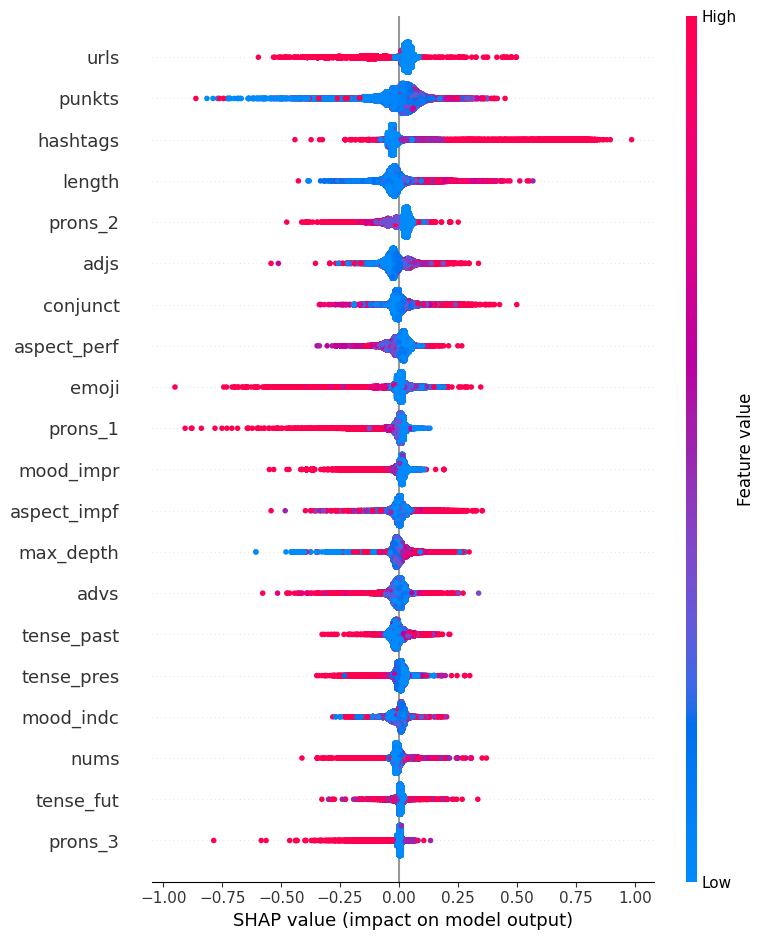

In [106]:
shap.summary_plot(shap_values, X)

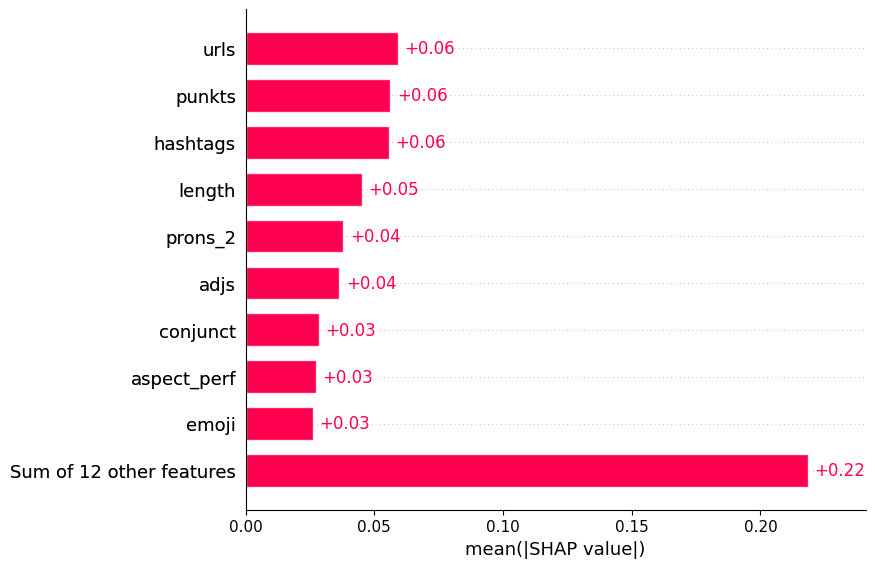

In [107]:
# By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the dataset.
shap.plots.bar(shap_values)

In [108]:
#for i,p in enumerate(predictions):
#  if p > 4.8 or p < 1.5:
#    print(i,p)

In [109]:
predictions[71684]
# Высокое значение открытости опыту

4.740238

In [110]:
dataset.iloc[71684]

user_id                                                                 816
post_text                 Подари мне уникальный подарок, пожалуйста.http...
Экстраверсия                                                           4.63
Доброжелательность                                                     3.33
Сознательность                                                         3.78
Нейротизм                                                              3.38
Открытость опыту                                                        4.7
Экстраверсия_3                                                            2
Доброжелательность_3                                                      1
Сознательность_3                                                          2
Нейротизм_3                                                               1
Открытость опыту_3                                                        2
Экстраверсия_5                                                            4
Доброжелател

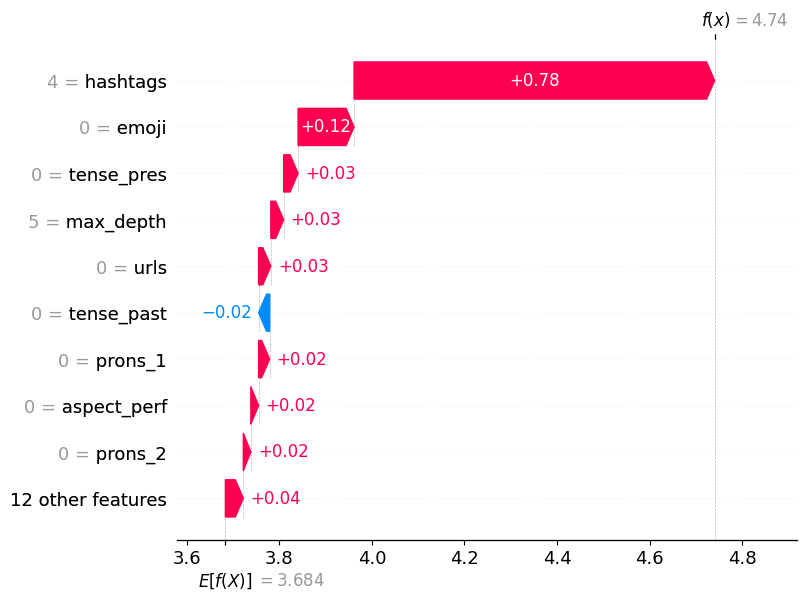

In [111]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[71684])

In [112]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[71684])

In [113]:
predictions[16187]
# Низкое значение сознательности

1.5075506

In [114]:
dataset.iloc[16187]

user_id                                    224
post_text                          Спасибки=))
Экстраверсия                               2.0
Доброжелательность                        3.11
Сознательность                            3.89
Нейротизм                                 4.25
Открытость опыту                           2.8
Экстраверсия_3                               0
Доброжелательность_3                         0
Сознательность_3                             2
Нейротизм_3                                  2
Открытость опыту_3                           0
Экстраверсия_5                               1
Доброжелательность_5                         2
Сознательность_5                             3
Нейротизм_5                                  3
Открытость опыту_5                           2
post_text_preprocessed    спасибки EMOJI PUNK 
Name: 16187, dtype: object

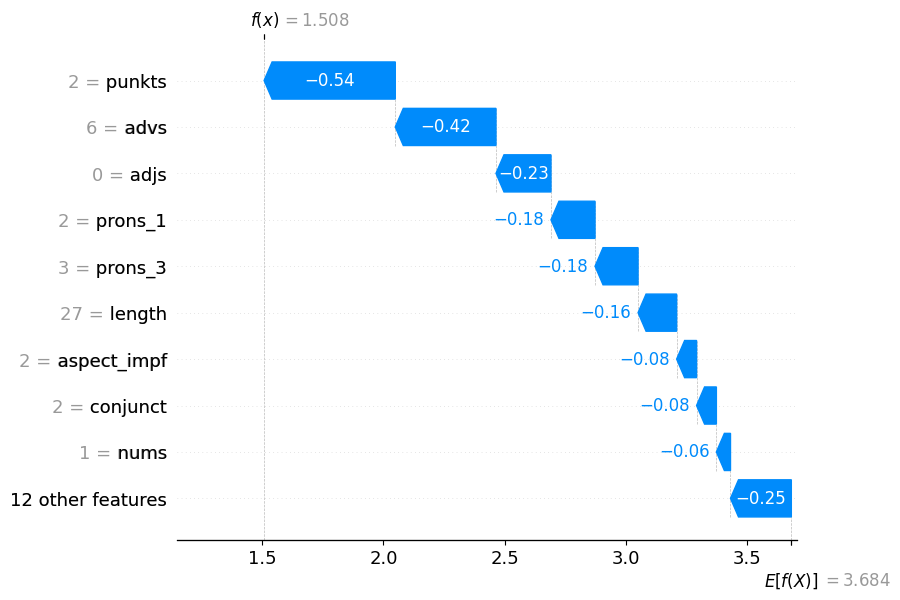

In [115]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[16187])

In [116]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[16187])

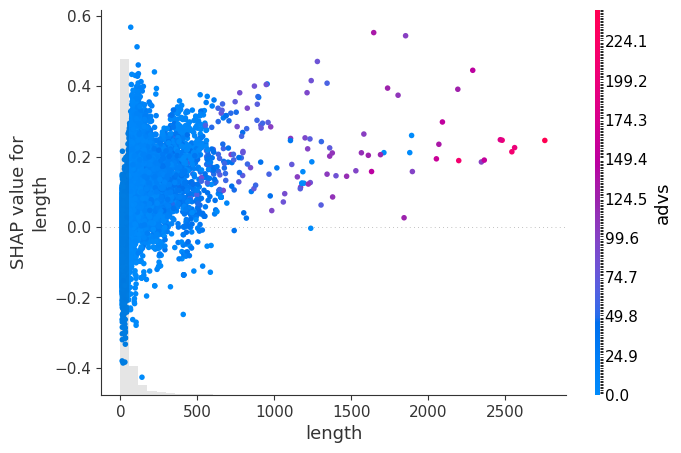

In [117]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"length"], color=shap_values)

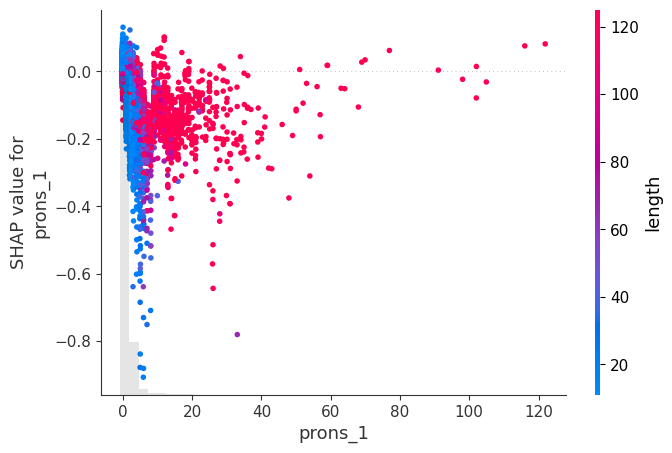

In [118]:
shap.plots.scatter(shap_values[:,"prons_1"], color=shap_values)

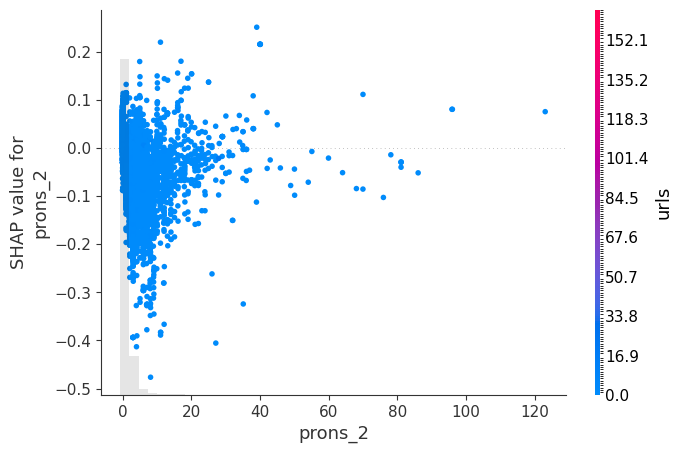

In [119]:
shap.plots.scatter(shap_values[:,"prons_2"], color=shap_values)

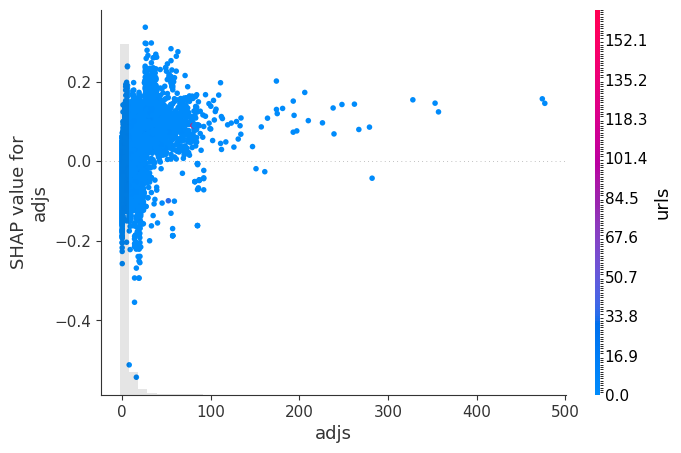

In [120]:
shap.plots.scatter(shap_values[:,"adjs"], color=shap_values)

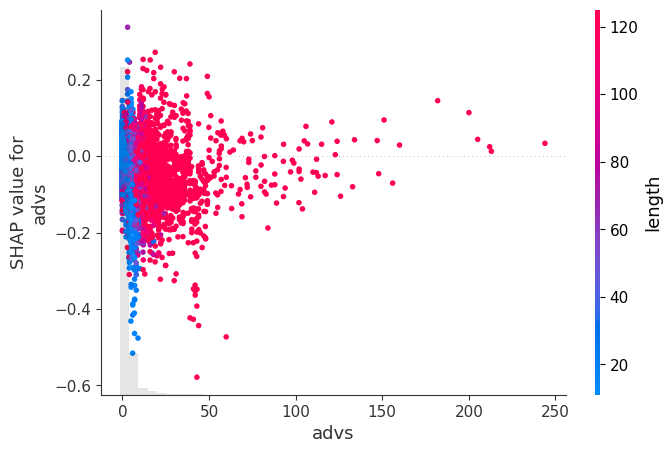

In [121]:
shap.plots.scatter(shap_values[:,"advs"], color=shap_values)

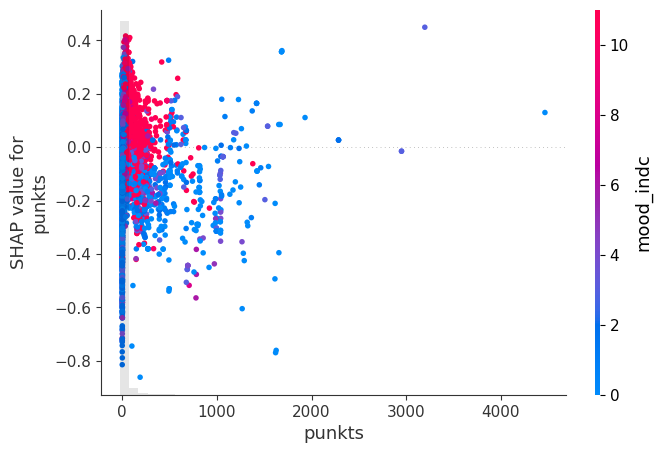

In [122]:
shap.plots.scatter(shap_values[:,"punkts"], color=shap_values)

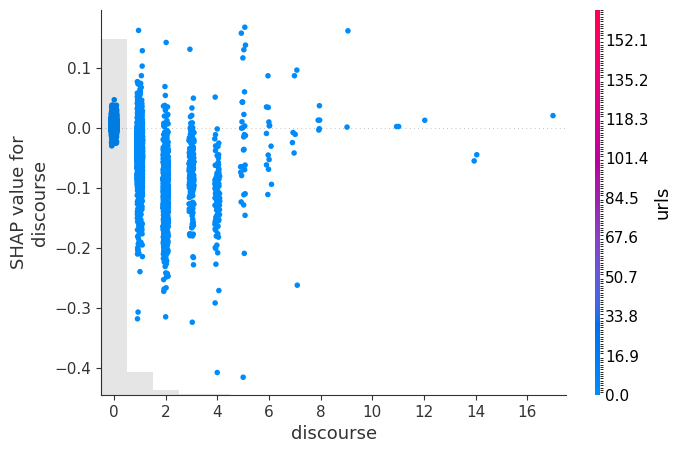

In [123]:
shap.plots.scatter(shap_values[:,"discourse"], color=shap_values)

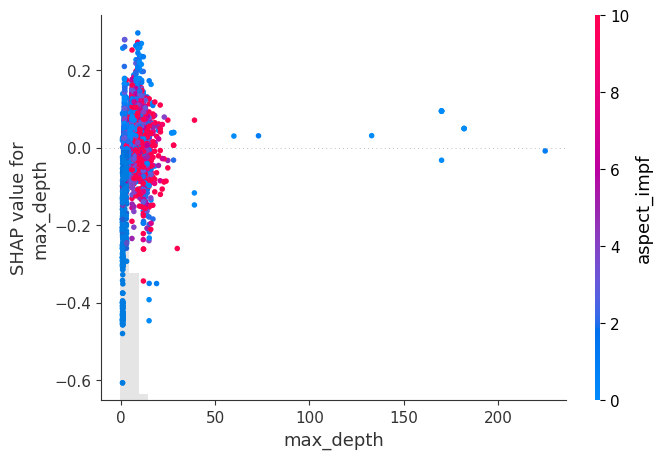

In [124]:
shap.plots.scatter(shap_values[:,"max_depth"], color=shap_values)

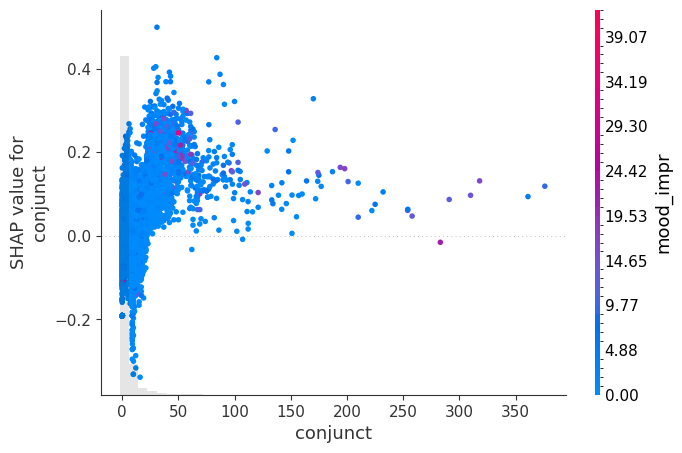

In [125]:
shap.plots.scatter(shap_values[:,"conjunct"], color=shap_values)

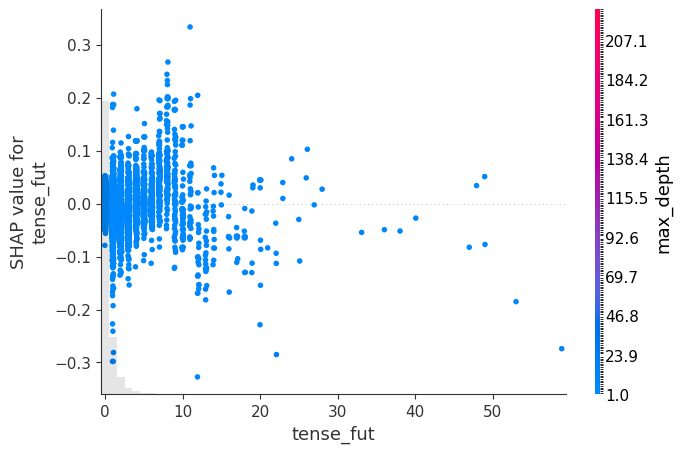

In [126]:
shap.plots.scatter(shap_values[:,"tense_fut"], color=shap_values)

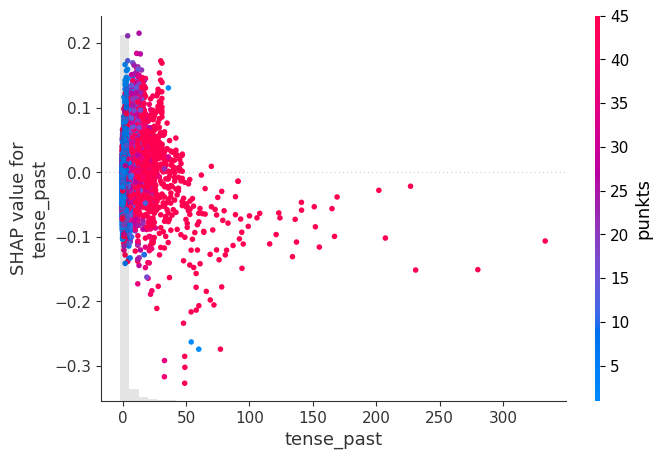

In [127]:
shap.plots.scatter(shap_values[:,"tense_past"], color=shap_values)

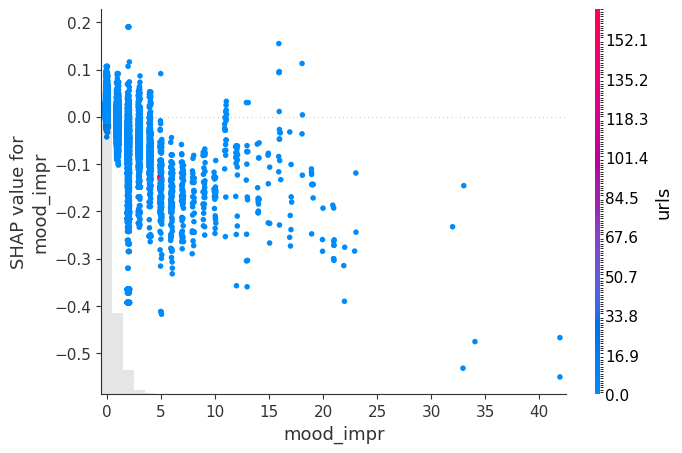

In [128]:
shap.plots.scatter(shap_values[:,"mood_impr"], color=shap_values)

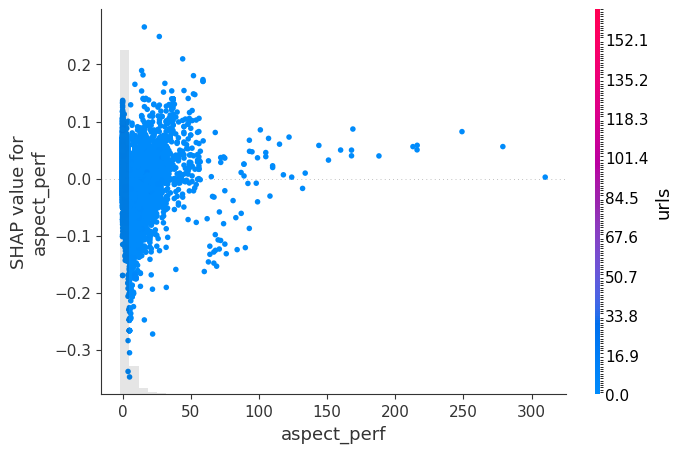

In [129]:
shap.plots.scatter(shap_values[:,"aspect_perf"], color=shap_values)

In [130]:
shap.initjs()
shap_values = explainer(X.head(100))
shap.plots.force(shap_values)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


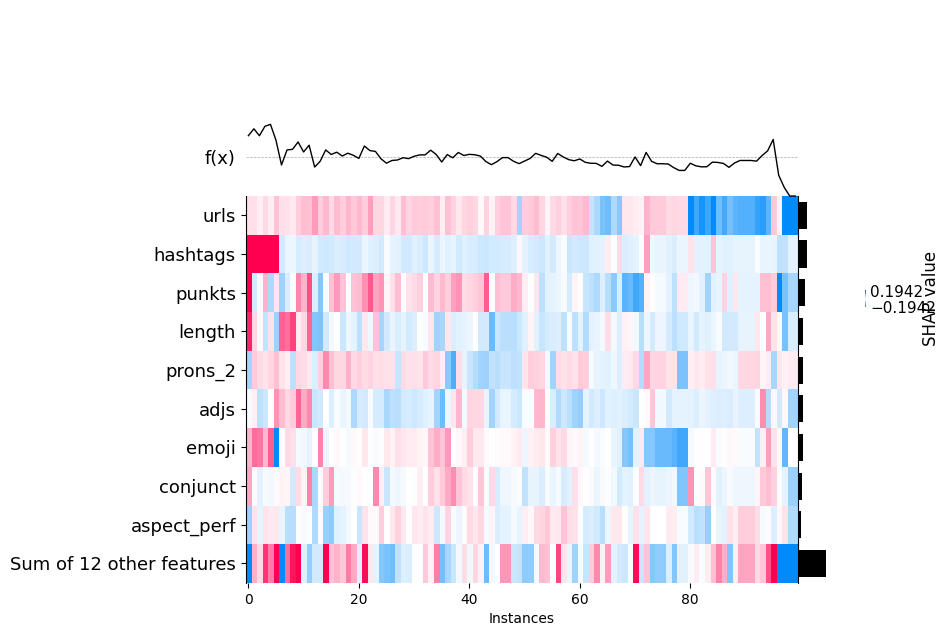

In [131]:
shap.plots.heatmap(shap_values)